In [ ]:
#install
#import sys
#import subprocess
# Upgrade pip
#subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
# Install torch and transformers
#subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "transformers"])


0

In [ ]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
import numpy as np



In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
from tqdm import tqdm

c:\Users\User\OneDrive\Área de Trabalho\data a\Review-Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# load CSV as df_model
df_clean = pd.read_csv("asos_reviews_clean.csv")
print(df_clean.head())

                         id  \
0  68b951e16796366d612c0a5a   
1  68b9508a183d3a0e366f4055   
2  68b93c80ca0e2a5da9e471f2   
3  68b8afadbca99a540889a0eb   
4  68b88f6f5a626c5041eea2c4   

                                                text  rating  \
0  I ordered tshirt of 83£ and did a partial retu...       1   
1  AWFUL! Still waiting for a refund that was app...       1   
2  Love asos fast delivery and selection - but th...       4   
3  Dreadful customer care. My order hasn’t arrive...       1   
4  I ordered a baseball cap from ASOS, as I am a ...       1   

                                      title  likes             date_published  \
0  Ordered tshirt of 83£ and did a partial…      0  2025-09-04 10:46:25+00:00   
1                                     AWFUL      0  2025-09-04 10:40:42+00:00   
2                          Great selection       0  2025-09-04 09:15:12+00:00   
3                    Dreadful customer care      0  2025-09-03 23:14:21+00:00   
4        I ordered a ba

In [4]:
df_model = df_clean.copy()

In [8]:
# Drop unwanted columns
df_model = df_model.drop(
    columns=[
        "id",
        "text",
        "title",
        "likes",
        "date_published",
        "name",
        "number_of_review",
        "country_code"
    ]
)


# Check what remains
print(df_model.head())


   rating                                         text_clean
0       1  i ordered tshirt of 83£ and did a partial retu...
1       1  awful! still waiting for a refund that was app...
2       4  love asos fast delivery and selection - but th...
3       1  dreadful customer care. my order hasn’t arrive...
4       1  i ordered a baseball cap from asos, as i am a ...


First Model TF-IDF + logistic regression model with 3 labels - positive, neutral, negative:

In [10]:
# create sentiment labels from rating columns
def rating_to_sentiment(r):
    if r >= 4:
        return "positive"
    elif r == 3:
        return "neutral"
    else:
        return "negative"

In [11]:
# Apply to DataFrame
df_model["label"] = df_model["rating"].apply(rating_to_sentiment)

In [12]:
# Quick check
print(df_model[["rating", "label"]].head())

   rating     label
0       1  negative
1       1  negative
2       4  positive
3       1  negative
4       1  negative


===== LOGISTIC REGRESSION METRICS =====
Accuracy: 0.9423076923076923
              precision    recall  f1-score   support

    negative       0.94      1.00      0.97        49
     neutral       0.00      0.00      0.00         1
    positive       0.00      0.00      0.00         2

    accuracy                           0.94        52
   macro avg       0.31      0.33      0.32        52
weighted avg       0.89      0.94      0.91        52



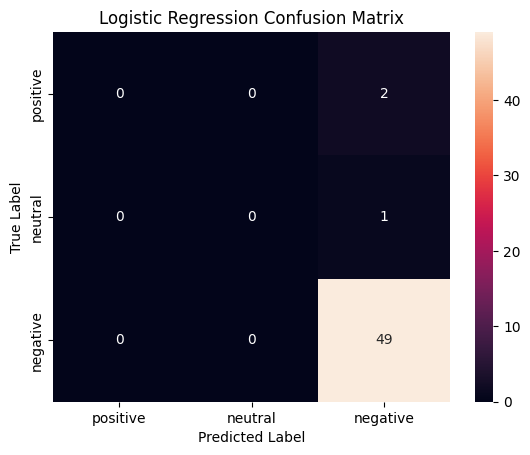

In [13]:
# Creating the model TF-IDF + logistic regression model

# split data for TF-IDF + logistic regression model
X = df_model["text_clean"]  # features
y = df_model["label"]       # target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF transformation (chatgbt code help)
vectorizer = TfidfVectorizer(ngram_range=(1,2))  # unigrams + bigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# handle imbalance (oversampling - there is much more negative reviews - chatgbt)
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_tfidf, y_train)

# train logistic Regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_res, y_train_res)

# predict on test set
y_pred = lr_model.predict(X_test_tfidf)

# print evaluation metrics
print("===== LOGISTIC REGRESSION METRICS =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0)) # chatgbt said to me add zero_division to avoid warnings

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred, labels=["positive","neutral","negative"])
sns.heatmap(cm_lr, annot=True, fmt="d",
            xticklabels=["positive","neutral","negative"],
            yticklabels=["positive","neutral","negative"])
plt.title("Logistic Regression Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


Second model TF-IDF + logistic regression model (binary) - positive and negative only:

===== LOGISTIC REGRESSION METRICS =====
Accuracy: 0.9807692307692307
              precision    recall  f1-score   support

    negative       0.98      1.00      0.99        50
    positive       1.00      0.50      0.67         2

    accuracy                           0.98        52
   macro avg       0.99      0.75      0.83        52
weighted avg       0.98      0.98      0.98        52



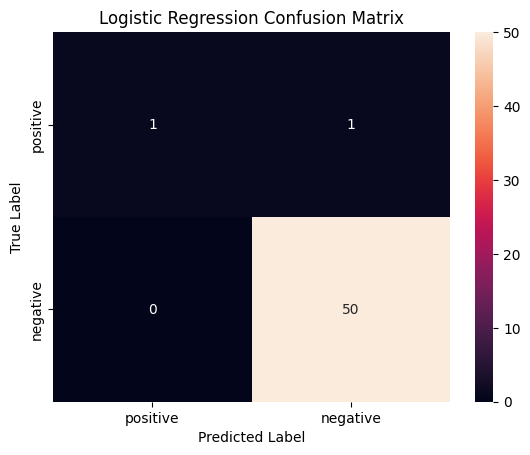

In [16]:
# testing label the data in positive and negative only and reduce test size to 0.1

# creating new binary labels
# Map rating to binary sentiment: positive vs negative
def rating_to_binary_sentiment(r):
    if r >= 4:
        return "positive"
    else:
        return "negative"
    
df_model["label_binary"] = df_model["rating"].apply(rating_to_binary_sentiment)

# training (small test size)
X = df_model["text_clean"]
y = df_model["label_binary"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#TF-IDF transformer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# handle imbalance
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train_tfidf, y_train)

# train logistic regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_res, y_train_res)

# Predict on test set
y_pred = lr_model.predict(X_test_tfidf)

# evaluation metrics
print("===== LOGISTIC REGRESSION METRICS =====")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred, labels=["positive","negative"])
sns.heatmap(cm_lr, annot=True, fmt="d",
            xticklabels=["positive","negative"],
            yticklabels=["positive","negative"])
plt.title("Logistic Regression Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()



third Model using Stratified 5-Fold Cross-Validation:

===== STRATIFIED 5-FOLD CROSS-VALIDATION METRICS =====
Average Accuracy: 0.94
Average Precision: 0.89
Average Recall: 0.94
Average F1-score: 0.91


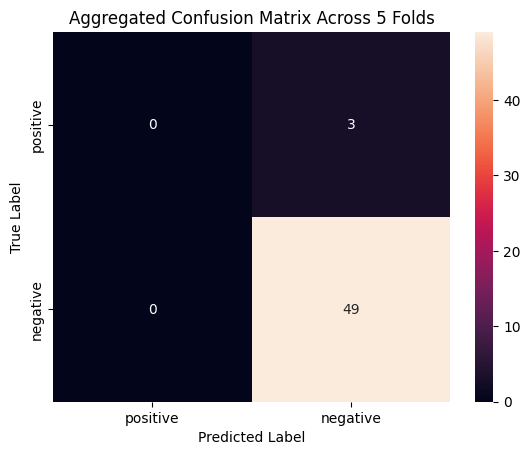

In [17]:
# Chatgpt code suggestion: Stratified 5-Fold Cross-Validation is a way to evaluate your model more reliably

# creating new binary labels
# Map rating to binary sentiment: positive vs negative
def rating_to_binary_sentiment(r):
    if r >= 4:
        return "positive"
    else:
        return "negative"
    
df_model["label_binary"] = df_model["rating"].apply(rating_to_binary_sentiment)

# Features and target
X = df_model["text_clean"].values
y = df_model["label_binary"].values


#TF-IDF transformer
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(X)

# stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_accuracy = []
all_precision = []
all_recall = []
all_f1 = []

# Initialize a confusion matrix accumulator
cm_total = np.zeros((2,2), dtype=int)
labels = ["positive","negative"]

for train_index, test_index in skf.split(X_tfidf, y):
    X_train, X_test = X_tfidf[train_index], X_tfidf[test_index]
    y_train, y_test = y[train_index], y[test_index]

# handle imbalance
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# train logistic regression
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_res, y_train_res)

# Predict on test set
y_pred = lr_model.predict(X_test)

# evaluation metrics
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, labels=labels, output_dict=True, zero_division=0)
    
all_accuracy.append(acc)
all_precision.append(report["weighted avg"]["precision"])
all_recall.append(report["weighted avg"]["recall"])
all_f1.append(report["weighted avg"]["f1-score"])

# Confusion matrix
cm_total += confusion_matrix(y_test, y_pred, labels=labels)

# display results
print("===== STRATIFIED 5-FOLD CROSS-VALIDATION METRICS =====")
print(f"Average Accuracy: {np.mean(all_accuracy):.2f}")
print(f"Average Precision: {np.mean(all_precision):.2f}")
print(f"Average Recall: {np.mean(all_recall):.2f}")
print(f"Average F1-score: {np.mean(all_f1):.2f}")

# Confusion matrix heatmap
sns.heatmap(cm_total, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Aggregated Confusion Matrix Across 5 Folds")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

Given the number of rows and more negative reviews in the dataset, I do not expect this model to be able to predict positive reviews as well as negative.

Using pre trained model to evaluate df_model:

Predicting Sentiment: 100%|██████████| 260/260 [01:10<00:00,  3.69it/s]


===== HUGGING FACE PRETRAINED SENTIMENT METRICS =====
Accuracy: 0.9923076923076923
              precision    recall  f1-score   support

    negative       0.99      1.00      1.00       248
    positive       1.00      0.83      0.91        12

    accuracy                           0.99       260
   macro avg       1.00      0.92      0.95       260
weighted avg       0.99      0.99      0.99       260



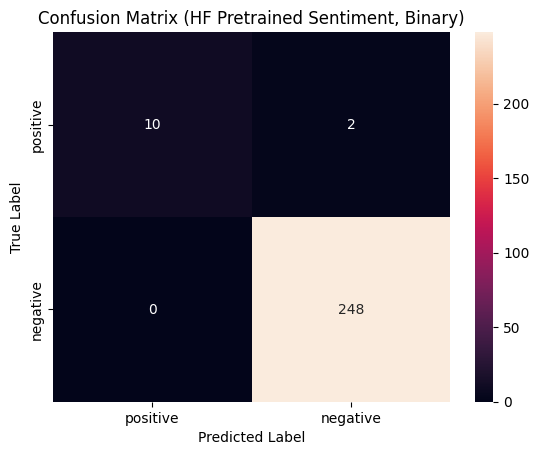

In [18]:
# load pretrained model
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Hugging Face model outputs 3 classes: 0=negative, 1=neutral, 2=positive
hf_to_binary = {0: "negative", 1: "negative", 2: "positive"}  # merge neutral with negative for binary

# preprocess text
texts = df_model["text_clean"].tolist()

# run prediction
pred_labels = []

for text in tqdm(texts, desc="Predicting Sentiment"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        scores = F.softmax(outputs.logits, dim=1).numpy()[0]
        predicted_class = np.argmax(scores)
        pred_labels.append(hf_to_binary[predicted_class])

df_model["hf_sentiment_pred"] = pred_labels

# evaluation binary
# Map your rating to binary label for comparison
df_model["label_binary"] = df_model["rating"].apply(lambda r: "positive" if r >= 4 else "negative")

y_true = df_model["label_binary"]
y_pred = df_model["hf_sentiment_pred"]

print("===== HUGGING FACE PRETRAINED SENTIMENT METRICS =====")
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=["positive","negative"])
sns.heatmap(cm, annot=True, fmt="d", xticklabels=["positive","negative"], yticklabels=["positive","negative"])
plt.title("Confusion Matrix (HF Pretrained Sentiment, Binary)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


Comparison table:
| Model                             | Accuracy | Precision | Recall   | F1-score |
| --------------------------------- | -------- | --------- | -------- | -------- |
| Logistic Regression (hold-out)    | \~0.98   | \~0.99    | \~0.75   | \~0.83   |
| Logistic Regression (5-fold CV)   | **0.94** | **0.89**  | **0.94** | **0.91** |
|Hugging Face RoBERTa (pre-trained) | **0.99** | **1.00**  | **0.92** | **0.95** |



Interpretation:

Hold-out Logistic Regression → looks strong (high accuracy), but this may be over-optimistic because of the small test set.

Cross-validation Logistic Regression → more realistic: slightly lower accuracy (0.94), but balanced precision/recall.

Pre-trained Transformer → best overall, with accuracy ~0.99, and very high F1. This shows the benefit of transfer learning even on small data.

Hold-out = quick, single split (can be unstable on small data).

Cross-validation = multiple splits, averaged performance (more reliable).

In [ ]:
# chatgpt
https://chatgpt.com/share/68d0f833-7070-8000-a5f8-0bb527d81395